# Temporal Trajectories of Microbiome Development

In this notebook we will investigate changes in microbiome composition over the the course of 6 months.

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

from qiime2 import Artifact

data_dir = "../data"
scripts_dir = "./src"

plt.style.use("../presentation_style")

# Check if Source Sans Pro is available
fonts = [f.name for f in fm.fontManager.ttflist]
if "Source Sans Pro" not in fonts:
    plt.rcParams['font.family'] = 'sans-serif'
    print("Source Sans Pro not found, using default sans-serif font.")

%matplotlib inline

In [2]:
try:
    num_cpus = int(os.environ["SLURM_CPUS_PER_TASK"])
except KeyError:
    num_cpus = os.cpu_count()

This script performs differential abundance analysis with ANCOM-BC2 with abundance data collapsed to genus level. Even though we have species level information, genus level is more approriate. The database that the classifier is used on does not curate species information as nicely as higher order information, which leads to misannotations. 

With ANCOM-BC2 we can add a random intercept to the model to control for intra-infant variability. This is done by specifying `--p-random-effects-formula "(1| infant_id)"`, analogous to R formulae.

In [3]:
! bash $scripts_dir/differential_abundance.sh

[2025-12-16 18:05:05] Starting Differential Abundance script
[2025-12-16 18:05:05] Filter feature table for minimal frequency and abundance in samples
/Users/flurinschindele/miniconda3/envs/microbEvolve/lib/python3.10/site-packages/emperor/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: ../data/raw/table_collapsed_abund.qza
[2025-12-16 18:05:29] Feature table filtered successfully
[2025-12-16 18:05:29] Collapse taxa to genus level and merge with feature table
/Users/flurinschindele/miniconda3/envs/microbEvolve/lib/python3.10/site-packages/emperor/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as ea

When looking at the created visualization, there is not one genus differentially abundant (q-value < 0.05) between the timepoints. This is quite surprising to us and warrants further investigation.

## Exploration of phylum level

We can take a look at raw changes of phyla abundance over time to get a feel for the data. 
We can import the data, collapse to the phylum level and convert to relative abundances. 
These steps could have been performed with QIIME plugins as well, but I preferred doing it manually this time.

In [5]:
table_collapsed_abund_l6 = Artifact.load(f"{data_dir}/raw/table_collapsed_abund_l6.qza")
df_table_collapsed_abund_l6 = table_collapsed_abund_l6.view(pd.DataFrame)
metadata_collapsed = pd.read_csv(f"{data_dir}/raw/metadata_collapsed.tsv", sep="\t", index_col=0)

/Users/flurinschindele/miniconda3/envs/microbEvolve/lib/python3.10/site-packages/emperor/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [6]:
def get_phylum(col_name):
    """
    Helper function to extract the phylum from a taxonomy string.
    """

    # Split the taxonomy string by semicolon
    parts = col_name.split(';')
    # Find the part that starts with 'p__'
    for part in parts:
        if part.strip().startswith('p__'):
            return part.strip()
    return "Unassigned"

In [7]:
df_phylum = df_table_collapsed_abund_l6.groupby(get_phylum, axis=1).sum()

df_phylum.head()

/var/folders/t2/68ltn7ds36523gbx2tkkj4zh0000gn/T/ipykernel_52869/1275988446.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_phylum = df_table_collapsed_abund_l6.groupby(get_phylum, axis=1).sum()


,p__Actinomycetota,p__Bacillota,p__Bacteroidota,p__Campylobacterota,p__Cyanobacteriota,p__Fusobacteriota,p__Methanobacteriota,p__Pseudomonadota,p__Thermodesulfobacteriota,p__Verrucomicrobiota
infant_1_2,369.0,18182.0,15.0,0.0,0.0,0.0,0.0,23680.0,0.0,1.0
infant_2_2,12968.0,5944.0,781.0,0.0,0.0,0.0,0.0,11486.0,0.0,0.0
infant_3_2,3866.0,193.0,10843.0,0.0,0.0,0.0,0.0,2678.0,0.0,2.0
infant_4_2,2179.0,24045.0,2692.0,0.0,1.0,4.0,1.0,3427.0,0.0,0.0
infant_5_2,35.0,16430.0,62.0,0.0,0.0,0.0,0.0,20958.0,0.0,4.0


In [8]:
df_phylum_with_metadata = df_phylum.merge(metadata_collapsed["timepoint"], left_index=True, right_index=True)
df_phylum_with_metadata_timepoint = df_phylum_with_metadata.groupby("timepoint").sum()
df_phylum_with_metadata_timepoint.head()

,p__Actinomycetota,p__Bacillota,p__Bacteroidota,p__Campylobacterota,p__Cyanobacteriota,p__Fusobacteriota,p__Methanobacteriota,p__Pseudomonadota,p__Thermodesulfobacteriota,p__Verrucomicrobiota
timepoint,,,,,,,,,,
2 months,83435.0,85782.0,65149.0,6.0,14.0,7.0,4.0,146274.0,0.0,20.0
4 months,83996.0,184655.0,118266.0,18.0,15.0,82.0,14.0,134253.0,285.0,10438.0
6 months,47889.0,227069.0,67106.0,4.0,21.0,209.0,6.0,48408.0,290.0,13629.0


In [ ]:
# Convert the count data to percentages based on timepoint
df_phylum_with_metadata_timepoint = df_phylum_with_metadata_timepoint.div(df_phylum_with_metadata_timepoint.sum(axis=1), axis=0)
print(df_phylum_with_metadata_timepoint.sum(axis=1)) # All rows should sum to 1
df_phylum_with_metadata_timepoint.head()

timepoint
2 months    1.0
4 months    1.0
6 months    1.0
dtype: float64


,p__Actinomycetota,p__Bacillota,p__Bacteroidota,p__Campylobacterota,p__Cyanobacteriota,p__Fusobacteriota,p__Methanobacteriota,p__Pseudomonadota,p__Thermodesulfobacteriota,p__Verrucomicrobiota
timepoint,,,,,,,,,,
2 months,0.219167,0.225332,0.171134,0.000016,0.000037,0.000018,0.000011,0.384233,0.000000,0.000053
4 months,0.157881,0.347082,0.222295,0.000034,0.000028,0.000154,0.000026,0.252345,0.000536,0.019619
6 months,0.118352,0.561175,0.165845,0.000010,0.000052,0.000517,0.000015,0.119635,0.000717,0.033683


Here we plot the relative abundance of pyhla over time. Bacillota seem to increase dramatically, Pseudomonadota decrease as well.

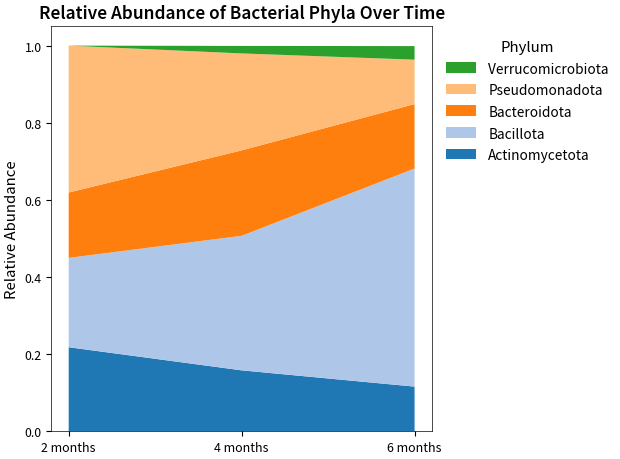

In [9]:
plot_df = df_phylum_with_metadata_timepoint[df_phylum_with_metadata_timepoint.columns[df_phylum_with_metadata_timepoint.max() > 0.01]].sort_index(axis=1)

fig, ax = plt.subplots(1, 1)

ax.stackplot(
    plot_df.index,
    plot_df.T,
    labels=plot_df.columns,
    colors=plt.cm.tab20.colors)

handles, labels = ax.get_legend_handles_labels()
# Remove p__ prefix for better readability
labels = [label[3:] if label.startswith("p__") else label for label in labels]
ax.legend(handles[::-1], labels[::-1], title="Phylum", loc='upper left', bbox_to_anchor=(1, 1))

ax.set_ylabel("Relative Abundance")
ax.set_title("Relative Abundance of Bacterial Phyla Over Time")

fig.tight_layout()
fig.savefig("../figures/phyla_relative_abundance_over_time.pdf")
fig.show()

## Exploration of Family level

I will look into the family level as well to see if there are similar trends. 
As there are some more taxa present on the family level, I will first do interactive plots with plotly. You can hover over a taxon at a timepoint to get additional data.

In [10]:
def get_familiy(col_name):
    # Split the taxonomy string by semicolon
    parts = col_name.split(';')
    # Find the part that starts with 'f__'
    for part in parts:
        if part.strip().startswith('f__'):
            return part.strip()
    return "Unassigned"

In [11]:
df_family = df_table_collapsed_abund_l6.groupby(get_familiy, axis=1).sum()
df_family_with_metadata = df_family.merge(metadata_collapsed["timepoint"], left_index=True, right_index=True)
df_family_with_metadata_timepoint = df_family_with_metadata.groupby("timepoint").sum()
df_family_with_metadata_timepoint.head()

df_family_with_metadata_timepoint = df_family_with_metadata_timepoint.div(df_family_with_metadata_timepoint.sum(axis=1), axis=0)
df_family_with_metadata_timepoint.head()

/var/folders/t2/68ltn7ds36523gbx2tkkj4zh0000gn/T/ipykernel_52869/3876221860.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_family = df_table_collapsed_abund_l6.groupby(get_familiy, axis=1).sum()


,f__Acetobacteraceae,f__Acidaminococcaceae,f__Actinomycetaceae,f__Akkermansiaceae,f__Atopobiaceae,f__Bacillaceae,f__Bacteroidaceae,f__Bifidobacteriaceae,f__Campylobacteraceae,f__Carnobacteriaceae,...,f__Rhizobiaceae,f__Rikenellaceae,f__Ruminococcaceae,f__Sphingomonadaceae,f__Staphylococcaceae,f__Streptococcaceae,f__Sutterellaceae,f__Tannerellaceae,f__Veillonellaceae,f__Yersiniaceae
timepoint,,,,,,,,,,,,,,,,,,,,,
2 months,0.000003,0.000271,0.001229,0.000053,0.000045,0.000013,0.098904,0.205841,0.000016,0.000116,...,0.000013,0.006977,0.000197,0.000047,0.005958,0.016840,0.003189,0.064320,0.112293,0.000008
4 months,0.000006,0.000008,0.002829,0.019619,0.000047,0.000175,0.184707,0.153888,0.000034,0.000415,...,0.000008,0.000241,0.000677,0.000023,0.000739,0.010135,0.005714,0.037200,0.226438,0.000103
6 months,0.000010,0.021573,0.000932,0.033683,0.000002,0.000035,0.158201,0.115406,0.000010,0.000143,...,0.000020,0.002558,0.000732,0.000037,0.000082,0.010148,0.001169,0.004911,0.467300,0.000000


In [12]:
import plotly.express as px

plotly_family_df = df_family_with_metadata_timepoint.reset_index().melt(id_vars="timepoint", var_name="Family", value_name="Abundance")
plotly_family_df.head()

,timepoint,Family,Abundance
0,2 months,f__Acetobacteraceae,0.000003
1,4 months,f__Acetobacteraceae,0.000006
2,6 months,f__Acetobacteraceae,0.000010
3,2 months,f__Acidaminococcaceae,0.000271
4,4 months,f__Acidaminococcaceae,0.000008


In [13]:
fig = px.area(
    plotly_family_df[plotly_family_df["Abundance"] > 0.01].sort_values(by="timepoint"),
    x="timepoint",
    y="Abundance",
    color="Family",
    title="Relative Abundance of Bacterial Families Over Time",
    labels={"timepoint": "Timepoint", "Abundance": "Relative Abundance"}
)
fig.show()

In [14]:
fig = px.bar(
    plotly_family_df[plotly_family_df["Abundance"] > 0.01].sort_values(by="timepoint"),
    x="timepoint",
    y="Abundance",
    color="Family",
    title="Relative Abundance of Bacterial Families Over Time",
    labels={"timepoint": "Timepoint", "Abundance": "Relative Abundance"}
)
fig.show()

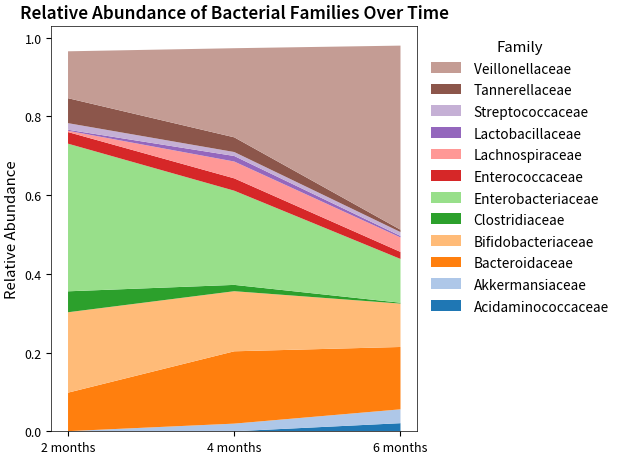

In [15]:
fig, ax = plt.subplots(1, 1)

plot_df = df_family_with_metadata_timepoint[df_family_with_metadata_timepoint.columns[df_family_with_metadata_timepoint.max() > 0.01]].sort_index(axis=1)

ax.stackplot(
    plot_df.index,
    plot_df.T,
    labels=plot_df.columns,
    colors=plt.cm.tab20.colors)

handles, labels = ax.get_legend_handles_labels()
# Remove f__ prefix for better readability
labels = [label[3:] if label.startswith("f__") else label for label in labels]
ax.legend(handles[::-1], labels[::-1], title="Family", loc='upper left', bbox_to_anchor=(1, 1))

ax.set_ylabel("Relative Abundance")
ax.set_title("Relative Abundance of Bacterial Families Over Time")

fig.tight_layout()
fig.savefig("../figures/family_relative_abundance_over_time.pdf")
fig.show()

These interactivate plotly charts also show that there are clear changes between timepoints. This makes the results from ANCOM-BC2 even more surprising. We will run ANCOM-BC2 again but this time with the full feature table. This way, we have many more samples than before and controlling for repeated sampling should still be valid, as we control for `infant_id` in the model.

If we do not find any differences in these conditions as well, it may just be that controlling for the infant is so crucial. It could simply be that there are no clear trends over the timepoints that are not explained by the intra-infant variability. 

We perform the roughly the same analysis as in the script above. We again filter taxa that are present in less then 10 samples. We increased this from 3 to 10, as we have ~130 samples now compared to the ~40 before. 

**Results:**

In this case, we identify multiple taxa that are differentially abundant. Multiple members of the Bacillota phylum are more abundant at 4, as well as at 6 months compared to 2 months. 
We can also observe a swap in Bacillota-members. 
The Clostridium and Staphylococcus genus are less abundant at 6 months than at two.

Klebsiella is also less abundant at 6 months compared to 2 months, which fits the decrease of some Pseuodomondata members reported in the literature.

In [14]:
%%bash -s "$data_dir" "$num_cpus"

# Receive Python variables as positional args
data_dir="$1"
num_cpus="$2"

set -euo pipefail

qiime feature-table filter-features \
    --i-table "$data_dir/raw/dada2_table.qza" \
    --p-min-samples 10 \
    --o-filtered-table "$data_dir/raw/filtered_table.qza"

qiime taxa collapse \
    --i-table "$data_dir/raw/filtered_table.qza" \
    --i-taxonomy "$data_dir/raw/taxonomy_weighted_stool.qza" \
    --p-level 6 \
    --o-collapsed-table "$data_dir/raw/filtered_table_l6.qza"

qiime composition ancombc2 \
    --i-table "$data_dir/raw/filtered_table_l6.qza" \
    --m-metadata-file "$data_dir/raw/metadata.tsv" \
    --p-fixed-effects-formula "timepoint" \
    --p-random-effects-formula "(1 | infant_id)" \
    --p-reference-levels "timepoint::2 months" \
    --p-p-adjust-method "BH" \
    --p-prevalence-cutoff 0.05 \
    --p-num-processes "$num_cpus" \
    --o-ancombc2-output "$data_dir/raw/ancombc_timepoint_all_l6.qza"

qiime tools export \
    --input-path "$data_dir/raw/ancombc_timepoint_all_l6.qza" \
    --output-path "$data_dir/raw/ancombc_timepoint_all_l6"

qiime composition ancombc2-visualizer \
    --i-data "$data_dir/raw/ancombc_timepoint_all_l6.qza" \
    --o-visualization "$data_dir/processed/ancombc_timepoint_all_l6.qzv"

/Users/flurinschindele/miniconda3/envs/microbEvolve/lib/python3.10/site-packages/emperor/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: ../data/raw/filtered_table.qza


/Users/flurinschindele/miniconda3/envs/microbEvolve/lib/python3.10/site-packages/emperor/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: ../data/raw/filtered_table_l6.qza


/Users/flurinschindele/miniconda3/envs/microbEvolve/lib/python3.10/site-packages/emperor/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[ANCOMBC2Output] to: ../data/raw/ancombc_timepoint_all_l6.qza


/Users/flurinschindele/miniconda3/envs/microbEvolve/lib/python3.10/site-packages/emperor/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported ../data/raw/ancombc_timepoint_all_l6.qza as ANCOMBC2OutputDirFmt to directory ../data/raw/ancombc_timepoint_all_l6


/Users/flurinschindele/miniconda3/envs/microbEvolve/lib/python3.10/site-packages/emperor/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved Visualization to: ../data/processed/ancombc_timepoint_all_l6.qzv


Here we do the same analysis for the family level:

In [ ]:
%%bash -s "$data_dir" "$num_cpus"

# Receive Python variables as positional args
data_dir="$1"
num_cpus="$2"

set -euo pipefail

qiime taxa collapse \
    --i-table "$data_dir/raw/filtered_table.qza" \
    --i-taxonomy "$data_dir/raw/taxonomy_weighted_stool.qza" \
    --p-level 5 \
    --o-collapsed-table "$data_dir/raw/filtered_table_l5.qza"

qiime composition ancombc2 \
    --i-table "$data_dir/raw/filtered_table_l5.qza" \
    --m-metadata-file "$data_dir/raw/metadata.tsv" \
    --p-fixed-effects-formula "timepoint" \
    --p-random-effects-formula "(1 | infant_id)" \
    --p-reference-levels "timepoint::2 months" \
    --p-p-adjust-method "BH" \
    --p-prevalence-cutoff 0.05 \
    --p-num-processes "$num_cpus" \
    --o-ancombc2-output "$data_dir/raw/ancombc_timepoint_all_l5.qza"

qiime tools export \
    --input-path "$data_dir/raw/ancombc_timepoint_all_l5.qza" \
    --output-path "$data_dir/raw/ancombc_timepoint_all_l5"

qiime composition ancombc2-visualizer \
    --i-data "$data_dir/raw/ancombc_timepoint_all_l5.qza" \
    --o-visualization "$data_dir/processed/ancombc_timepoint_all_l5.qzv"

python(57732) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/flurinschindele/miniconda3/envs/microbEvolve/lib/python3.10/site-packages/emperor/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: ../data/raw/filtered_table_l5.qza


/Users/flurinschindele/miniconda3/envs/microbEvolve/lib/python3.10/site-packages/emperor/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Error while terminating subprocess (pid=57732): 


Plugin error from composition:

  '...' in falschem Kontext benutzt

Debug info has been saved to /var/folders/t2/68ltn7ds36523gbx2tkkj4zh0000gn/T/qiime2-q2cli-err-bpsk4olf.log


We can also perform feature volatility analysis. This is a ML-based action to identify features that are important for predicting a target variable, in this case the timepoint. By looking at the resulting visualization, we can also get insight into the inter-infant differences. 

In the volatility plot, we can observe strong differences between infants. This also underscores the results we have obtained when looking into beta diversity in more detail (see `03_diversity_significance.ipynb`). 

The Veillonellaceae family shows an overall strong increase in abundance. Nevertheless, we see that multiple infants do not follow this trend. A handful of infants show no colonization with Veillonellaceae over all 6 months, whereas many other show a drastic increase. 

The same is true for Enterobacteriaceae. Here we see average decrease in abundace, but two infants show an increase in abundance from 4 to 6 months.

These results underscore the volatility of the gut microbiome at this young age. Even though we observe global trends, the variability between infants is large. 
Based on published literature, the microbiome composition is expected to stabilize over the following months and years into adulthood. 

In [17]:
! qiime longitudinal feature-volatility \
        --i-table $data_dir/raw/filtered_table_l5.qza \
        --m-metadata-file $data_dir/raw/metadata_numeric_timepoints.tsv \
        --p-state-column "timepoint" \
        --p-individual-id-column "infant_id" \
        --p-random-state 2025 \
        --p-n-jobs $num_cpus \
        --p-n-estimators 100 \
        --p-parameter-tuning \
        --p-missing-samples "ignore" \
        --output-dir $data_dir/processed/feature_volatility_l5

python(58078) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


/Users/flurinschindele/miniconda3/envs/microbEvolve/lib/python3.10/site-packages/emperor/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[RelativeFrequency] to: ../data/processed/feature_volatility_l5/filtered_table.qza
Saved FeatureData[Importance] to: ../data/processed/feature_volatility_l5/feature_importance.qza
Saved Visualization to: ../data/processed/feature_volatility_l5/volatility_plot.qzv
Saved Visualization to: ../data/processed/feature_volatility_l5/accuracy_results.qzv
Saved SampleEstimator[Regressor] to: ../data/processed/feature_volatility_l5/sample_estimator.qza
